<a href="https://colab.research.google.com/github/sonamkshenoy/Neural-Networks-Using-PyTorch/blob/master/CNN_And_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Outline


*   Downloading dataset (CIFAR10)
*   Dataloader in torch.utils
*   Visualising images
*   Single and multiple convolutional layers
*   LeNet
*   Training LeNet
*   Training on GPU
*   Simple visualisation
*   Exercises



In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Data loading

In [ ]:
import torchvision
import torchvision.transforms as transforms
# to apply functions when downloading only; similar to "map" (here, converts each image "ToTensor" while downloading so that can use PyTorch tensors on them)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download = True, transform = transforms.ToTensor())

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
# Dataset has labels in terms of indices
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True)

In [ ]:
dataiter = iter(trainloader)

# Running each time accesses the next batch
images, labels = dataiter.next()

print(images.shape)

print(images[0].shape)
print(labels[0].item()) # Can access till labels[3] only since batch_size = 4

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
2


# Visualise data

In [ ]:
# Access first image
img = images[0] # 3,32,32 (32x32 with 3 channels)
print(type(img))

<class 'torch.Tensor'>


In [ ]:
npimg = img.numpy()
print(npimg.shape)

(3, 32, 32)


In [ ]:
# Just shifting axes such that order is (x,y,z)
npimg = np.transpose(npimg, (1,2,0)) # z (3 channels) was the first label (0), place it at last
print(npimg.shape)

(32, 32, 3)


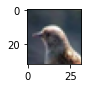

In [ ]:
plt.figure(figsize = (1,1))
plt.imshow(npimg) # To plot images in Matplotlib
plt.show()

Remember the label of images[0] was = 2 (bird)!

In [ ]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

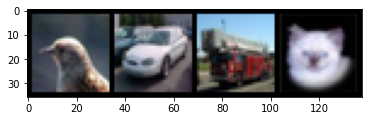

bird car truck cat


In [ ]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

# Single Convolutional Layer

In [ ]:
import torch.nn as nn

In [ ]:
# Inherit class FirstCNN from nn.Module
class FirstCNN(nn.Module):

  def __init__(self):
    super(FirstCNN, self).__init__()
    # Convolution translates in 2 directions only though image tensor is 4D - including batch size (hence Conv2d)
    # (channels in each image, number of output channels, kernel size)
    self.conv1 = nn.Conv2d(3, 16, 3) 
    # padding = (1,1) => output size = 32 x 32 
    # stride = (2,2) => output size = 16 x 16

  def forward(self, x):
    # forward propagates the input x thus training the weights of above network (no backpropagation)
    x = self.conv1(x)
    return x

In [ ]:
net = FirstCNN() # calls __init__()

In [ ]:
out = net(images) # this parameter passed to forward() as x

# Shape of output of first layer  
# (batch size, #channels, width - x cood, height - y cood)  
out.shape

torch.Size([4, 16, 30, 30])

In [ ]:
# all the parameters of the model
for param in net.parameters():
  print(param.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])


First: Wts of (#channels/kernels, input channel depth, kernel width, kernel height)   
Second: Biases of each of 16 neurons (kernel)

In [ ]:
# Plot just one channel
# So from torch.Size([4, 16, 30, 30]), extracting 1st image's, first layer (entire width and height) 
# out is output of 1st layer
out1 = out[0,0,:,:].detach().numpy()
print(out1.shape)

(30, 30)


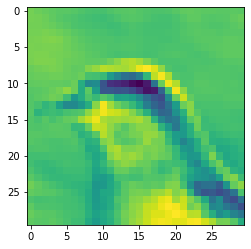

In [ ]:
plt.imshow(out[0,0,:,:].detach().numpy())
plt.show()

Outline of bird (image 0) from first layer

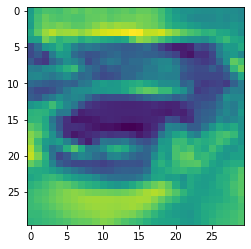

In [ ]:
plt.imshow(out[1,0,:,:].detach().numpy())
plt.show()

Outline of car (image 1)

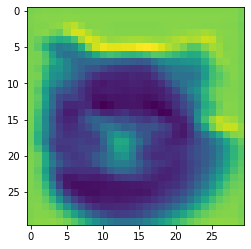

In [ ]:
plt.imshow(out[3,0,:,:].detach().numpy())
plt.show()

Outline of cat (image 3)

(Weights and biases randomly initialised, hence nothing intelligible is happening. Just idea of how output of the first CNN layer looks like).

# Deep Convolutional Network

In [ ]:
class FirstCNN_v2(nn.Module):
  def __init__(self):
    super(FirstCNN_v2, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 8, 3), # (N, 3, 32, 32) -> (N, 8, 30, 30) [ shrunk by one since no padding ]
        # (batch_size, depth, width of image (i.e. before shrink), height) -> (batch_size, #channels, width after shrink, height)
        # immediately output = input of next layer
        nn.Conv2d(8, 16, 3), # (N, 8, 30, 30) -> (N, 16, 28, 28)
    )

  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

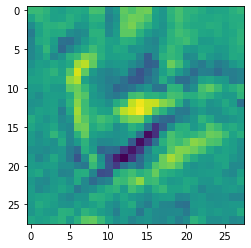

In [ ]:
plt.imshow(out[0, 0, :, :].detach().numpy())

Outline of bird (nothing to interpret again), yet can see correspondence - light and dark regions

In [ ]:
class FirstCNN_v2(nn.Module):
  def __init__(self):
    super(FirstCNN_v2, self).__init__()
    self.model = nn.Sequential(
        # N is batch size
        nn.Conv2d(3, 6, 5), # (N, 3, 32, 32) -> (N, 6, 28, 28) since again no padding and kernel = 5 so shrinks on 2 on both sides
        nn.AvgPool2d(2, stride = 2), # (N, 6, 28, 28) -> (N, 6, 14, 14)
        nn.Conv2d(6, 16, 5), # (N, 6, 14, 14) -> (N, 16, 10, 10)
        nn.AvgPool2d(2, stride = 2) # (N, 16, 10, 10) -> (N, 16, 5, 5)
    )
    # Avgpool is 2d too (since depth of kernel is always same as that of input)

  def forward(self, x):
    x = self.model(x)
    return x

In [ ]:
net = FirstCNN_v2()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

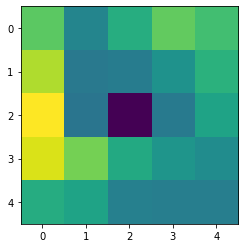

In [ ]:
plt.imshow(out[0, 0, :, :].detach().numpy())

Output of 2nd layer

# LeNet

In [ ]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    self.cnn_model = nn.Sequential(
        # LeNet uses Tanh as activation function - immediately after convolution applied (non-linearity)

        nn.Conv2d(3, 6, 5), # (N, 3, 32, 32) -> (N, 6, 28, 28)
        nn.Tanh(),

        # depth is 6
        nn.AvgPool2d(2, stride = 2), # (N, 6, 28, 28) -> (N, 6, 14, 14)

        nn.Conv2d(6, 16, 5), # (N, 6, 14, 14) -> (N, 16, 10, 10)
        nn.Tanh(),

        nn.AvgPool2d(2, stride = 2) # (N, 16, 10, 10) -> (N, 16, 5, 5)
    )

    # fully connected
    self.fc_model = nn.Sequential(
        # (#inputs, #output neurons)
        nn.Linear(400, 120), # (N,400) -> (N, 120) since 16*5*5 = 400 (flatten to single dimension tensor)
        nn.Tanh(),
        nn.Linear(120, 84), # (N, 120) -> (N, 84)
        nn.Tanh(),
        nn.Linear(84, 10) # (N, 84) -> (N, 10)
    )
    # Hence number of labels in the final output is equal to the number of images fed (N)
    # Not using softmax in last layer since not essential for inferences ( i.e. just mentioning which class ). Just need the label with highest value
    # Max after softmax is same as that before softmax (but will use it to calc grad.)

  def forward(self,x):
    print (x.shape)

    # First apply cnn
    x = self.cnn_model(x)
    print(x.shape)

    # Flattening is DONE HERE. Not recommended in model, though can.
    # Torch .view() corresponds to numpy .reshape()
    # First index is the size, everything else collapsed
    x = x.view(x.size(0), -1)
    print(x.shape)

    x = self.fc_model(x)
    print(x.shape)
    return x

Note:  
Convolution used to vary depth. (Done in Conv step)**bold text**  
Stride and padding used to vary width and height. (Done in Pooling Step)

In [ ]:
net = LeNet()
out = net(images)

torch.Size([4, 3, 32, 32])
torch.Size([4, 16, 5, 5])
torch.Size([4, 400])
torch.Size([4, 10])


In [ ]:
print(out)

tensor([[-0.0563,  0.0529,  0.0378, -0.0313,  0.0085, -0.1203, -0.0011,  0.0998,
          0.0819, -0.0320],
        [-0.0595,  0.0554,  0.0402, -0.0433,  0.0155, -0.1242, -0.0157,  0.0910,
          0.0890, -0.0382],
        [-0.0689,  0.0374,  0.0273, -0.0391,  0.0155, -0.1406, -0.0174,  0.0936,
          0.0775, -0.0312],
        [-0.0206,  0.0655,  0.0394, -0.0224, -0.0105, -0.1004, -0.0143,  0.0879,
          0.1199, -0.0521]], grad_fn=<AddmmBackward>)


In [ ]:
max_values, pred_class = torch.max(out.data, 1)
print(pred_class)

tensor([7, 7, 7, 8])


# Training LeNet

In [ ]:
class LeNet_clean(nn.Module):
  def __init__(self):
    super(LeNet_clean, self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.Tanh(),

        nn.AvgPool2d(2, stride = 2),
        nn.Conv2d(6, 16, 5),

        nn.Tanh(),

        nn.AvgPool2d(2, stride = 2)
    )

    self.fc_model = nn.Sequential(
        nn.Linear(400, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )

  def forward(self,x):

    x = self.cnn_model(x)
    x = x.view(x.size(0), -1)
    x = self.fc_model(x)
    return x

In [ ]:
batch_size = 128
trainset = torchvision.datasets.CIFAR10(root='./data', train = True, download = True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testset = torchvision.datasets.CIFAR10(root='./data', train = False, download = True, transform = transforms.ToTensor())
# Shuffle false since we are not going to evaluate on it again and again, just once predict (one evaluation)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def evaluation(dataloader):
  # this time don't have to dataiter and then dataiter.next; the for loop does all that
  total = 0
  correct = 0
  for data in dataloader:
    inputs, labels = data
    outputs = net(inputs)
    _,pred = torch.max(outputs.data, 1) # second arg: dimension along which max (across cols so 1)
    total += labels.size(0) # Total number of inputs processed so far
    correct += (pred==labels).sum().item() # all are tensors so item()
  return 100*correct/total

In [ ]:
net = LeNet_clean()

In [ ]:
import torch.optim as optim

# Cross entropy applied only after softmax (which we haven't done)
loss_fn = nn.CrossEntropyLoss()

# Pass all parameters that have to be optimised (also here is where we are connecting the Adam Optimizer to current CNN - LeNet)
opt = optim.Adam(net.parameters())

Epoch: 0/16, Test acc: 46.84, Training accuracy: 48.34
Epoch: 1/16, Test acc: 49.68, Training accuracy: 51.78
Epoch: 2/16, Test acc: 51.81, Training accuracy: 54.72
Epoch: 3/16, Test acc: 52.40, Training accuracy: 55.89
Epoch: 4/16, Test acc: 53.15, Training accuracy: 57.53
Epoch: 5/16, Test acc: 54.06, Training accuracy: 59.30
Epoch: 6/16, Test acc: 53.67, Training accuracy: 60.14
Epoch: 7/16, Test acc: 54.26, Training accuracy: 60.87
Epoch: 8/16, Test acc: 55.02, Training accuracy: 61.88
Epoch: 9/16, Test acc: 54.90, Training accuracy: 63.01
Epoch: 10/16, Test acc: 55.07, Training accuracy: 64.17
Epoch: 11/16, Test acc: 54.89, Training accuracy: 64.82
Epoch: 12/16, Test acc: 55.49, Training accuracy: 66.03
Epoch: 13/16, Test acc: 54.89, Training accuracy: 65.73
Epoch: 14/16, Test acc: 55.18, Training accuracy: 66.74
Epoch: 15/16, Test acc: 55.07, Training accuracy: 67.19


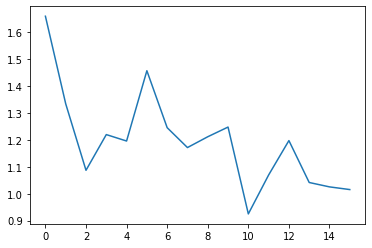

CPU times: user 7min 40s, sys: 11.7 s, total: 7min 52s
Wall time: 7min 53s


In [ ]:
%%time

loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0): # Start enumeration from 0
    
    inputs, labels = data

    # Reset previous gradients, if any
    opt.zero_grad()

    # Forward pass
    outputs = net(inputs)

    # Compute loss after forward pass
    loss = loss_fn(outputs, labels)

    # Do backward propagation of loss
    loss.backward()

    # Take a step of optimising all parameters based on the backprop by using update rule (Adam)
    opt.step()

    loss_arr.append(loss.item())

  loss_epoch_arr.append(loss.item())

  print("Epoch: %d/%d, Test acc: %0.2f, Training accuracy: %0.2f" %(epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))

plt.plot(loss_epoch_arr)
plt.show()

# Move LeNet to GPU

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def evaluation(dataloader):
  total = 0
  correct = 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs)
    _,pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred==labels).sum().item() 
  return 100*correct/total

In [ ]:
net = LeNet_clean().to(device)
loss_fn = nn.CrossEntropyLoss()
# we are not passing any hyperparameters (L2 regulariser to avoid overfitting - weight decay, etc)
opt = optim.Adam(net.parameters())

Thus shifted inputs, labels and model to GPU. The rest (Adam optimizer, Loss function etc) are just hyperparameters. Not things to shift to GPU.

In [ ]:
%%time

loss_arr = []
loss_epoch_arr = []
max_epochs = 16

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):    
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    # opt already moved to GPU
    opt.zero_grad()

    # outputs on gpu since net and inputs on gpu
    outputs = net(inputs)

    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()

  print("Epoch: %d/%d" %(epoch, max_epochs))

Epoch: 0/16
Epoch: 1/16
Epoch: 2/16
Epoch: 3/16
Epoch: 4/16
Epoch: 5/16
Epoch: 6/16
Epoch: 7/16
Epoch: 8/16
Epoch: 9/16
Epoch: 10/16
Epoch: 11/16
Epoch: 12/16
Epoch: 13/16
Epoch: 14/16
Epoch: 15/16
CPU times: user 9min 30s, sys: 9.85 s, total: 9min 40s
Wall time: 9min 44s


In [ ]:
print("Test acc: %0.2f, Training accuracy: %0.2f" %(evaluation(testloader), evaluation(trainloader)))

Test acc: 51.35, Training accuracy: 57.53


# Basic Visualisation

### Visualising output of first convolutional layer

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

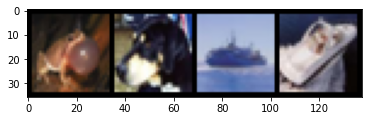

In [ ]:
imshow(torchvision.utils.make_grid(images))

In [ ]:
# If don't move model to cpu, next command will give type mismatch error (images on gpu and net on cpu)
net = net.to("cpu")

In [ ]:
out = net(images)
print(out.shape)

torch.Size([4, 10])


Final Output of model is 4 images with probability of 10 classes each

In [ ]:
# net contains cnn_model + fc NN. 
# net.cnn contains the sequential part (all layers in it)
# [0] accesses only the first layer of the sequential part i.e. the conv2d layer. Apply only to images
out = net.cnn_model[0](images)
out.shape

torch.Size([4, 6, 28, 28])

Ouput of only first layer is (N, 6, 28, 28) - already estimated before

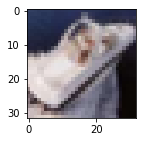

In [ ]:
image_id = 3
plt.figure(figsize = (2,2))
imshow(images[image_id,])

This was the input.  
Now let's see the output of each of the six channels (not rgb, but something we can't interpret) as a result of the first layer for the fourth image only.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


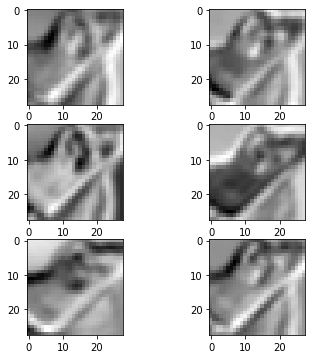

In [ ]:
plt.figure(figsize = (6,6))
plt.subplot(321) # 3rows, 2 cols
for i in range(6):
  ax1 = plt.subplot(3, 2, i+1)
  # Each time, same image (i.e. 4th image) but channel number increases by 1 and its complete dimension (complete x and y so ":")
  plt.imshow(out[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()

### Visualising output of second convolutional layer

In [ ]:
out2 = net.cnn_model[3](images)

**RuntimeError: Given groups=1, weight of size [16, 6, 5, 5], expected input[4, 3, 32, 32] to have 6 channels, but got 3 channels instead**  
Can't pass directly to third layer, have to pass through each layer before that to undergo those transformations first

In [ ]:
out2 = net.cnn_model[3](net.cnn_model[2](net.cnn_model[1](net.cnn_model[0](images))))

In [ ]:
out2.shape

torch.Size([4, 16, 10, 10])

Correct (N, 16, 10, 10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


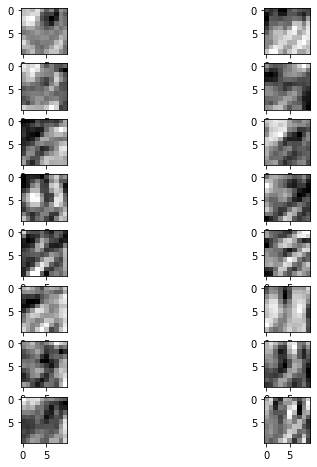

In [ ]:
plt.figure(figsize = (8,8))
plt.subplot(821)
for i in range(16): # 16 channels
  ax1 = plt.subplot(8,2,i+1)
  plt.imshow(out2[image_id, i, :, :].detach().numpy(), cmap="binary")
plt.show()

Size has shrunk from 28 x 28 to 10 x 10 (thus the decrese in size) due to the average pooling.